In [74]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import *

%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format

In [75]:
users = UsersData('../data/users')
tweets = TweetsData('../data/tweets')

In [76]:
df = tweets.df.loc[:][:]

# Exploratory Data Analysis

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729129 entries, 1331706590525874184 to 1000259808442961920
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   userid                    729129 non-null  string        
 1   user_display_name         729129 non-null  string        
 2   user_screen_name          729129 non-null  string        
 3   user_reported_location    545336 non-null  string        
 4   user_profile_description  684476 non-null  string        
 5   user_profile_url          448380 non-null  string        
 6   follower_count            729129 non-null  int64         
 7   following_count           729129 non-null  int64         
 8   account_creation_date     729129 non-null  datetime64[ns]
 9   account_language          729129 non-null  string        
 10  tweet_language            603007 non-null  string        
 11  tweet_text                729129 n

<IPython.core.display.Javascript object>


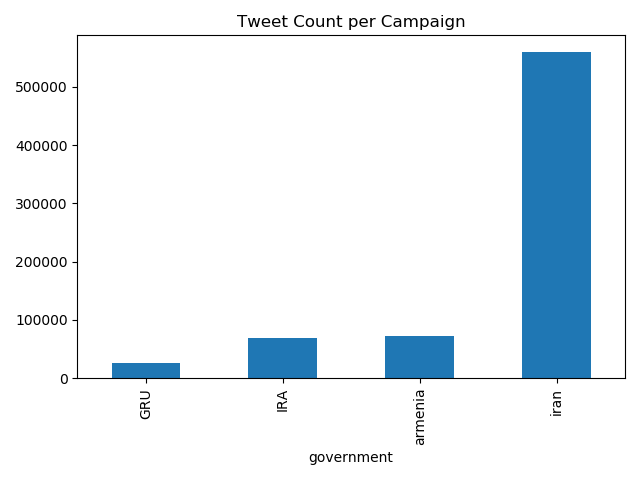

In [78]:
(df.groupby('government')
  .size()
).plot(kind='bar', title='Tweet Count per Campaign')
plt.tight_layout()

In [27]:
iran = df[df['campaign'] =='iran202012']

In [28]:
(iran
    .groupby('userid')
    .sum()
    .loc[:]['like_count']
    .describe()
    .astype('int')
)[['mean','std','min','max']]

mean      13928
std      125374
min           0
max     1799708
Name: like_count, dtype: int64

split-apply-combine:

In [49]:
campaign_filter = (df['campaign'] =='iran202012')
iran = df.loc[:][campaign_filter]

In [72]:
test = df['in_reply_to_tweetid'].dropna().convert_dtypes()

In [73]:
type(test.iloc[0])

numpy.int64

In [66]:
type(df['in_reply_to_tweetid'].astype('string',errors='ignore').iloc[0])

numpy.float64

In [40]:
(iran
 .groupby('like_count')
 .sum()
 .sort_index(ascending=False)
 .reset_index()
)

,like_count,follower_count,following_count,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_tweetid,quote_count,reply_count,retweet_count,has_quote
0,63863,2439,1164,0.00,0.00,0.00,0.00,1155,1385,26269,0.00
1,18145,2439,1164,0.00,0.00,0.00,0.00,102,166,4503,0.00
2,12618,254,136,0.00,0.00,0.00,0.00,1109,504,9967,0.00
3,9124,2439,1164,0.00,0.00,0.00,0.00,297,444,4419,0.00
4,8311,2439,1164,0.00,0.00,0.00,0.00,124,423,1409,0.00
...,...,...,...,...,...,...,...,...,...,...,...
869,4,2034624556,6376581,640673507183126773760.00,285862017959656128512.00,0.00,0.00,4491,6315,121294,230.00
870,3,2948044008,9855649,1252082809383203897344.00,494132029181525098496.00,0.00,0.00,4993,7676,149004,396.00
871,2,4403448386,18874259,3594122658260214349824.00,969601268521873178624.00,0.00,0.00,5021,9871,175801,782.00
872,1,6933029004,64621055,22358185159104999194624.00,2315805818808995151872.00,0.00,0.00,4202,17190,187070,1875.00


In [ ]:
f_avg = df_sample[f_filter]['Height'].mean()

m_avg = df_sample[m_filter]['Height'].mean()

print(f_avg,m_avg)

In [ ]:
df_output = pd.DataFrame({'Gender':['f','m'],'Height':[f_avg,m_avg]})
df_output

In [ ]:
df_sample.groupby('Gender').mean()

looping:

In [ ]:
obj = df.groupby('Outlet_Location_Type')
obj

In [ ]:
obj.groups

In [ ]:
for name,group in obj:
    print(name,'contains',group.shape[0],'rows')

In [ ]:
obj.get_group('Tier 1')

aggregation:

In [ ]:
df.groupby('Outlet_Location_Type').agg([np.mean,np.median])

In [ ]:
df.groupby(['Outlet_Location_Type','Outlet_Establishment_Year'],as_index=False).agg({'Outlet_Size':pd.Series.mode,'Item_Outlet_Sales':np.mean})

In [ ]:
df.groupby(['Outlet_Type','Item_Type']).agg(mean_MRP=('Item_MRP',np.mean),mean_Sales=('Item_Outlet_Sales',np.mean))

In [ ]:
df['Item_Weight'] = df.groupby(['Item_Fat_Content','Item_Type'])['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

filtering:

In [ ]:
def filter_func(x):
    return x['Item_Weight'].std() < 3

df_filter = df.groupby(['Item_Weight']).filter(filter_func)
df_filter.shape

In [ ]:
df_apply = df.groupby(['Outlet_Establishment_Year'])['Item_MRP'].apply(lambda x: x - x.mean())
df_apply

In [ ]:
# make queries that look like this
df = (data_df[['userid','user_',"geo","id"]]
            .reset_index()
            .groupby("user") 
            .agg({"id":"count","bio":"first","geo":"first"}) 
            .sort_values("id",ascending = False)
            .rename(columns={'id':'tweet_count'})
        ).head(15)

## Original Tweets vs. Retweets

In [ ]:
def get_original_tweets(tweets):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets['rt_screen_name'] = tweets_df['is_retweet'].apply(
                            lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets["retweeted_id"] = tweets_df['is_retweet'].apply(
                            lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets

def get_retweets(tweets):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(
                            lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets["retweeted_id"] = tweets_df["retweeted_status"].apply(
                            lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets

def get_in_reply(tweets):
    # Copy the 'in_reply' columns to the new dataframe
    tweets["in_reply_to_userid"] = tweets_df["in_reply_to_userid"]
    return tweets